## Experiment 1: For ImageNet, under benign condition  

In [1]:
import timm
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import INFO
import numpy as np
import faiss
import copy
from tqdm import tqdm

from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import clip

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda:3


In [3]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode().splitlines()
print(imagenet_classes[0])

tench


### Dataset Loading 

In [4]:
import os
from torchvision import datasets, transforms
import torch

print(f"Step 1: Loading dataset with resize transform...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) 
])

val_data_dir = 'dataset/imagenet_validation' 
test_data_dir = 'dataset/imagenet_tests'

val_dataset = datasets.ImageFolder(os.path.join(val_data_dir), transform=transform) 

test_datasets = {
    f'test{i}': datasets.ImageFolder(os.path.join(test_data_dir, f'test{i}'), transform=transform)
    for i in range(1, 11)
}

print(f"Validation samples: {len(val_dataset)}")
print(f"Validation samples: {len(test_datasets['test1'])}")

Step 1: Loading dataset with resize transform...
Validation samples: 30000
Validation samples: 2004


In [5]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4) 
test_loader = DataLoader(test_datasets['test1'], batch_size=1, shuffle=False, num_workers=4)  

## Base Models 

In [6]:
from torchvision.models import (
    resnet18, resnet34,  
    resnet50, resnet101, resnet152, vgg11, vgg19,
    densenet201, inception_v3, googlenet, efficientnet_b0, efficientnet_b7,
    squeezenet1_1, shufflenet_v2_x1_0, mobilenet_v2, convnext_tiny
)
from torchvision.models.vision_transformer import vit_b_16, vit_l_16 
import timm  

In [7]:
def evaluate_pool(pool, test_loader):
    print("\nEvaluating individual classifiers on test set...")

    for i, model in enumerate(pool):
        model = model.to(device)  # <- Ensure model is on the correct device
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.squeeze().long().to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.numel()
        acc = correct / total * 100
        print(f"Classifier {i+1} ({model.__class__.__name__}): Accuracy = {acc:.2f}%")


In [8]:
trained_pool = [
        vit_l_16(pretrained=True).eval(),  
        # efficientnet_b7(pretrained=True).eval(),  
        vit_b_16(pretrained=True).to(device).eval(), 
        vgg19(pretrained=True).to(device).eval(),
        inception_v3(pretrained=True).to(device).eval(),
        googlenet(pretrained=True, aux_logits=True, transform_input=False).to(device).eval(), 
        mobilenet_v2(pretrained=True).to(device).eval(), 
        efficientnet_b0(pretrained=True).to(device).eval(), 
        # shufflenet_v2_x1_0(pretrained=True).eval(), 
        # squeezenet1_1(pretrained=True).eval(), 
        # resnet18(pretrained=True).eval(),
        # resnet34(pretrained=True).eval(),
        # resnet50(pretrained=True).eval(),
        resnet101(pretrained=True).to(device).eval()
       ]

In [9]:
trained_pool = [ 
        vgg19(pretrained=True).to(device).eval(), 
        inception_v3(pretrained=True).to(device).eval(), 
         # mobilenet_v2(pretrained=True).to(device).eval(),  
        vit_b_16(pretrained=True).to(device).eval(), 
        efficientnet_b0(pretrained=True).to(device).eval(), 
        resnet101(pretrained=True).to(device).eval()
       ]

In [10]:
evaluate_pool(trained_pool, test_loader)


Evaluating individual classifiers on test set...
Classifier 1 (VGG): Accuracy = 69.36%
Classifier 2 (Inception3): Accuracy = 66.52%
Classifier 3 (VisionTransformer): Accuracy = 79.34%
Classifier 4 (EfficientNet): Accuracy = 75.60%
Classifier 5 (ResNet): Accuracy = 75.60%


## Helper Models 

In [8]:
def visualize_test_and_roc(test_img, roc_imgs, local_labels, class_names=None):
    def denormalize(img_tensor, mean, std):
        mean = torch.tensor(mean).view(-1, 1, 1).to(img_tensor.device)
        std = torch.tensor(std).view(-1, 1, 1).to(img_tensor.device)
        return img_tensor * std + mean

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225] 

    k = roc_imgs.size(0)
    ncols = min(k, 5)
    nrows = 1 + (k + ncols - 1) // ncols  # one row for test image + RoC images
    
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    
    # Plot test image
    plt.subplot(nrows, ncols, 1)
    denorm_img = denormalize(test_img, mean, std).clamp(0, 1)
    img_np = TF.to_pil_image(denorm_img.cpu())
    plt.imshow(img_np)
    plt.title("Test Image")
    plt.axis("off")
    
    # Plot RoC images
    for i in range(k):
        plt.subplot(nrows, ncols, i + 2)
        denorm_img = denormalize(roc_imgs[i], mean, std).clamp(0, 1)
        img_np = TF.to_pil_image(denorm_img.cpu())
        label = local_labels[i]
        if class_names:
            label = class_names[label]
        plt.imshow(img_np)
        plt.title(f"RoC #{i+1}\nLabel: {label}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [9]:
def get_last_linear_layer(model):
    """
    Try to find the last Linear layer in the model,
    using common attribute names and fallback to scanning modules.
    """
    name = model.__class__.__name__.lower()

    # Common last layer attribute names to try (ViT, EfficientNet, etc)
    candidate_attrs = ['head', 'heads', 'classifier', 'fc', 'mlp_head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            layer = getattr(model, attr)
            # If it's directly a Linear layer
            if isinstance(layer, nn.Linear):
                return layer
            # If Sequential or Module, find last Linear inside it
            if isinstance(layer, nn.Sequential) or isinstance(layer, nn.Module):
                # Find last Linear inside this attribute recursively
                last_linear = None
                for child in reversed(list(layer.modules())):
                    if isinstance(child, nn.Linear):
                        last_linear = child
                        break
                if last_linear is not None:
                    return last_linear

    # Fallback: scan all modules and pick the last Linear
    last_linear = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last_linear = m
    if last_linear is not None:
        return last_linear

    raise RuntimeError("No Linear layer found in model")


def get_features_before_last_linear(model, x):
    features = {}

    def find_last_linear(module):
        last_linear = None
        for m in module.modules():
            if isinstance(m, torch.nn.Linear):
                last_linear = m
        return last_linear

    last_linear = find_last_linear(model)
    if last_linear is None:
        raise RuntimeError("No Linear layer found in model")

    def hook(module, input, output):
        features['feat'] = input[0].detach()

    handle = last_linear.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(x)

    handle.remove()

    if 'feat' not in features:
        raise RuntimeError("Failed to capture features from last linear layer")

    return features['feat']

In [10]:
def fire_check(local_labels, preds, per_class_min=1):
    local_labels = np.asarray(local_labels)

    # If preds are logits/probs, convert to labels
    preds = np.asarray(preds)
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)

    # Classes present in the RoC (unique, not repeated)
    classes_in_roc = np.unique(local_labels)

    # Check: for each class c in RoC, there is at least `per_class_min` correct prediction
    missing = []
    for c in classes_in_roc:
        mask = (local_labels == c)
        n_correct = int(np.sum(preds[mask] == c))
        if n_correct < per_class_min:
            missing.append((int(c), n_correct))  # track which class is short

    fire_ok = (len(missing) == 0)
    return fire_ok

## VisionDES 

In [11]:

class VisionDES: 
    def __init__(self, dsel_dataset, pool): 
        self.dsel_dataset = dsel_dataset
        self.dsel_loader = DataLoader(dsel_dataset, batch_size=32, shuffle=False) 
        self.dino_model = timm.create_model('vit_base_patch16_224.dino', pretrained=True).to(device)
        self.dino_model.eval()  
        self.pool = pool 

        self.suspected_model_votes = [] 
        
        
    def dino_embedder(self, images):
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        return self.dino_model.forward_features(images)


    def fit(self): 
        dsel_embeddings = []
        dsel_labels = []
    
        with torch.no_grad():
            for imgs, labels in tqdm(self.dsel_loader):
                imgs = imgs.to(device)
                embs = self.dino_embedder(imgs).cpu()  
                dsel_embeddings.append(embs)
                dsel_labels.append(labels)
    
        # Keep as tensor
        dsel_embeddings_tensor = torch.cat(dsel_embeddings).detach().cpu()  
        cls_tensor = dsel_embeddings_tensor[:, 0, :]  
    
        # Convert to NumPy
        cls_embeddings = np.ascontiguousarray(cls_tensor.numpy(), dtype='float32')
        self.dsel_embeddings = cls_embeddings
        self.dsel_labels = torch.cat(dsel_labels).numpy()
    
        # Build FAISS index
        embedding_dim = cls_embeddings.shape[1]
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.index.add(cls_embeddings)

    
    def get_output_size(self, model):
        """
        Returns the output size (number of classes) from various model architectures.
        """
        if hasattr(model, 'fc'):
            return model.fc.out_features
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                return model.classifier[-1].out_features
            else:
                return model.classifier.out_features
        elif hasattr(model, 'heads'):  # ViT / DINO from torchvision
            return model.heads.head.out_features
        elif hasattr(model, 'head'):  # ViT/Swin from timm
            return model.head.out_features
        else:
            raise AttributeError("Cannot determine output size of the model.")


    def predict_weighted_robust(self, test_img, k=7, return_logits=False, explain=False, top=False, n=3, use_fire=False, per_class_min=1, 
                                use_sim=False, sim_threshold=0, alpha=0.6, knorae=False):
        # Step 1: Get DINO CLS embedding for the test image
        img_for_dino = test_img.unsqueeze(0).to(device)

        with torch.no_grad():
            test_emb = self.dino_model.forward_features(img_for_dino).cpu().numpy().astype('float32')
            test_emb = test_emb[:, 0, :]  # CLS token only
    
        # Step 2: Find k nearest neighbors in FAISS (Region of Competence)
        distances, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = self.dsel_labels[neighbor_idxs]
        local_labels = np.array(local_labels).flatten()
    
        # Step 3: Get RoC images
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)
    
        # Step 4: Evaluate classifiers — compute competence and feature similarity
        competences, soft_outputs, feature_similarities, passed_fire, correct_counts = [], [], [], [], []
    
        test_img_batch = test_img.unsqueeze(0).to(device)
    
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                outputs = clf(roc_imgs)
                preds = outputs.argmax(dim=1).cpu().numpy()
                correct = (preds == local_labels).sum()
                competence = correct / k
                competences.append(competence)
                correct_counts.append(correct)

                # 🔥 FIRE check: at least one correct per class
                fire_ok = fire_check(local_labels, preds, per_class_min=per_class_min) 
                passed_fire.append(fire_ok)

                logits = clf(test_img.unsqueeze(0).to(device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

                # Feature similarity using ResNet embeddings
                test_feat = get_features_before_last_linear(clf, test_img.unsqueeze(0).to(device))
                roc_feats = get_features_before_last_linear(clf, roc_imgs)
                mean_feat = roc_feats.mean(dim=0, keepdim=True)

                sim = cosine_similarity(test_feat / test_feat.norm(), mean_feat / mean_feat.norm(), dim=1)
                feature_similarities.append(sim.item())

        # 5️⃣ KNORA-E selection logic
        if knorae: 
            selected_indices = []
            required_correct = k  # start with strict condition (all correct)
            while required_correct >= 1 and not selected_indices:
                selected_indices = [i for i, c in enumerate(correct_counts) if c >= required_correct]
                required_correct -= 1
    
            if not selected_indices:  # failsafe: fall back to all models
                selected_indices = list(range(len(self.pool)))

            for i in range(len(self.pool)): 
                if i not in selected_indices: 
                    competences[i] = 0.0 
                    # feature_similarities[i] = 0.0 
    
        # Step 5: Combine competence & feature similarity into a score
        if use_sim: 
            selected_feature_sims = [s if s > sim_threshold  else 0.0 for s in feature_similarities]
            combined_scores = [(c * alpha) + (s * (1-alpha)) for c, s in zip(competences, selected_feature_sims)]
        else: 
            combined_scores = [c for c in competences] 


        if use_fire:
            combined_scores = [s if passed_fire[i] else 0.0 for i, s in enumerate(combined_scores)]

        # Step 6: Select
        if top: 
            top_n_idx = np.argsort(combined_scores)[-n:]  # indices of top-n models
            top_n_idx = top_n_idx.tolist()
        
            total_score = sum([combined_scores[i] for i in top_n_idx])
            if total_score == 0:
                weights = [1.0 / n] * n
            else:
                weights = [combined_scores[i] / total_score for i in top_n_idx]
        else: 
            total_score = sum(combined_scores)
            if total_score == 0:
                weights = [1.0 / len(self.pool)] * len(self.pool)
            else:
                weights = [s / total_score for s in combined_scores]  
    
        # Step 7: Weighted aggregation of top-n classifier outputs
        num_classes = self.get_output_size(self.pool[0])
        weighted_logits = torch.zeros(num_classes).to(device)

        if top: 
            for idx, weight in zip(top_n_idx, weights):
                weighted_logits += weight * soft_outputs[idx]
        else: 
            for prob, weight in zip(soft_outputs, weights):
                weighted_logits += weight * prob
            
    
        # Step 8: Keep track of suspected attacked model
        min_sim_idx = int(np.argmin(feature_similarities))
        self.suspected_model_votes.append(min_sim_idx)

        # Step 8: Optional explainability
        if explain:
            print("\nExplainability Report:")
            for idx, (clf, comp, sim, weight, prob, fire) in enumerate(zip(self.pool, competences, feature_similarities, weights, soft_outputs, passed_fire)):
                pred_class = prob.argmax().item()
                conf = prob[pred_class].item()
                topk = torch.topk(prob, k=2)
                print(f"Model #{idx}: {clf.__class__.__name__}")
                print(f"  - Competence: {comp:.4f}")
                print(f"  - Feature similarity: {sim:.4f}")
                print(f"  - Combined weight: {weight:.4f}")
                print(f"  - 🔥 FIRE: {fire}")
                print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                print("-" * 50)
    
            print(f"\n🧠 Final prediction: {weighted_logits.argmax().item()}")
            top5 = torch.topk(weighted_logits, k=5)
            print(f"🔝 Top-5 predictions:")
            for i in range(5):
                print(f"  - Class {top5.indices[i].item()}: {top5.values[i].item():.4f}")
    
            print("\nModel weight distribution:")
            for idx, w in enumerate(weights):
                print(f"  Model #{idx}: {w:.4f}")
            print(f"Suspected attacked model: Model #{min_sim_idx} ({self.pool[min_sim_idx].__class__.__name__})")
    
            print("\nRoC visualization:")
            visualize_test_and_roc(test_img.squeeze(0), roc_imgs, local_labels)
            print(distances)

        if return_logits:
            return weighted_logits
        return weighted_logits.argmax().item()

    def predict(self, dataloader): 
        total = 0
        correct = 0 

        dataset_offset = 0 


In [14]:
des_model.pool = trained_pool 

### Evaluate VisionDES 

In [16]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_des_with_fails(des_model, dataloader, dataset, average="weighted"):
    total = 0
    correct = 0
    failed_indices = []
    dataset_offset = 0  # to map dataloader batches back to dataset indices
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Testing VisionDES"):
            imgs, labels = imgs.to(device), labels.to(device)

            preds = []
            for idx_in_batch, img in enumerate(imgs):
                pred = des_model.predict_weighted_robust(
                    img, k=5, return_logits=False, explain=False, top=False, n=3, 
                    use_fire=False, per_class_min=1, use_sim=True, sim_threshold=0, 
                    alpha=0.6, knorae=True
                )
                preds.append(pred)

                # Collect failures (map batch index to dataset index)
                if pred != labels[idx_in_batch].item():
                    failed_indices.append(dataset_offset + idx_in_batch)

            preds = torch.tensor(preds).to(device)

            # accumulate results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            dataset_offset += labels.size(0)

    acc = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=average, zero_division=0
    )
    
    print(f"✅ Accuracy: {acc*100:.2f} | Precision: {precision*100:.2f} | Recall: {recall*100:.2f} | F1: {f1*100:.2f}")
    
    return failed_indices


In [14]:
trained_pool = [
        vit_l_16(pretrained=True).to(device).eval(),  
        vgg19(pretrained=True).to(device).eval(),
        inception_v3(pretrained=True).to(device).eval(),
        # googlenet(pretrained=True, aux_logits=True, transform_input=False).to(device).eval(), 
        mobilenet_v2(pretrained=True).to(device).eval(), 
        efficientnet_b0(pretrained=True).to(device).eval(), 
        resnet101(pretrained=True).to(device).eval()
       ]

In [ ]:
des_model = VisionDES(val_dataset, trained_pool)
des_model.fit()

 26%|█████████████████                                                | 246/938 [01:39<05:11,  2.22it/s]

In [29]:
test_name = "test1"

test_loader = DataLoader(test_datasets[test_name], batch_size=1, shuffle=False, num_workers=4)   

failed_indices = evaluate_des_with_fails(des_model, test_loader, test_datasets[test_name])  

Testing VisionDES: 100%|████████████████████████████████████████████| 2004/2004 [07:17<00:00,  4.58it/s]

✅ Accuracy: 79.44 | Precision: 80.75 | Recall: 79.44 | F1: 77.68


True class: 5

Explainability Report:
Model #0: VGG
  - Competence: 0.8571
  - Feature similarity: 0.7501
  - Combined weight: 0.2462
  - 🔥 FIRE: True
  - Predicted class: 6 with confidence 0.7927
  - Top-5: [6, 5] → [0.793, 0.186]
--------------------------------------------------
Model #1: VisionTransformer
  - Competence: 0.8571
  - Feature similarity: 0.8573
  - Combined weight: 0.2592
  - 🔥 FIRE: True
  - Predicted class: 5 with confidence 0.5274
  - Top-5: [5, 6] → [0.527, 0.347]
--------------------------------------------------
Model #2: EfficientNet
  - Competence: 0.8571
  - Feature similarity: 0.5981
  - Combined weight: 0.2278
  - 🔥 FIRE: True
  - Predicted class: 6 with confidence 0.7042
  - Top-5: [6, 5] → [0.704, 0.24]
--------------------------------------------------
Model #3: ResNet50
  - Competence: 0.8571
  - Feature similarity: 0.9194
  - Combined weight: 0.2667
  - 🔥 FIRE: True
  - Predicted class: 6 with confidence 0.9757
  - Top-5: [6, 5] → [0.976, 0.024]
------

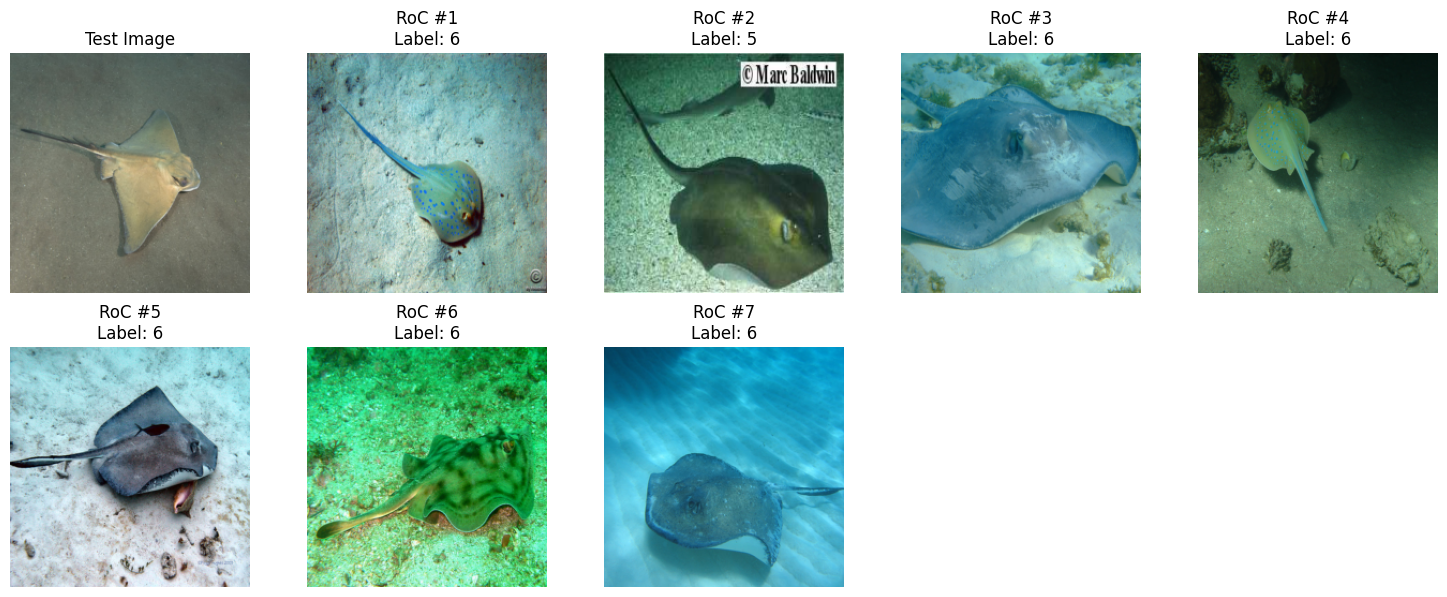

[[2756.7192 2845.8354 2980.8599 3091.4348 3127.55   3190.0083 3382.395 ]]


6

In [93]:
index = 11

print(f"True class: {test_datasets[test_name][index][1]}") 

des_model.predict_weighted_robust(test_datasets[test_name][index][0], explain=True, use_sim=True, use_fire=False, knorae=False)

## Static Ensemble 

In [18]:
class SoftVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images, return_probs=False):
        probs = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                softmaxed = torch.softmax(outputs, dim=1)
                probs.append(softmaxed.cpu().numpy())
        mean_probs = np.mean(np.stack(probs), axis=0)
        if return_probs:
            return mean_probs
        return np.argmax(mean_probs, axis=1)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        with torch.no_grad():
            model_probs = []
            for model in self.models:
                logits = model(image.to(self.device))
                softmaxed = torch.softmax(logits, dim=1)
                model_probs.append(softmaxed.cpu().numpy())
            mean_probs = np.mean(np.stack(model_probs), axis=0)
            probs = mean_probs[0]
            pred = np.argmax(probs)
            return probs, pred

In [19]:
import torch
import numpy as np
from collections import Counter

class HardVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images):
        all_preds = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu().numpy())

        # shape: [n_models, batch_size] → transpose to [batch_size, n_models]
        all_preds = np.stack(all_preds, axis=0).T  

        # majority vote for each sample
        final_preds = []
        for preds in all_preds:
            most_common = Counter(preds).most_common(1)[0][0]
            final_preds.append(most_common)

        return np.array(final_preds)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        votes = []
        with torch.no_grad():
            for model in self.models:
                logits = model(image.to(self.device))
                pred = torch.argmax(logits, dim=1).item()
                votes.append(pred)

        # majority voting
        final_pred = Counter(votes).most_common(1)[0][0]
        return votes, final_pred


In [20]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

def evaluate_individual_models(pool, dataloader, average="weighted"):
    results = {}
    
    with torch.no_grad():
        for i, model in enumerate(pool):
            model = model.to(device)
            model.eval()
            total = 0
            correct = 0
            all_preds = []
            all_labels = []
            
            for imgs, labels in dataloader:
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            acc = correct / total
            precision, recall, f1, _ = precision_recall_fscore_support(
                all_labels, all_preds, average=average, zero_division=0
            )
            
            results[f"Model_{i+1}"] = {
                "Accuracy": acc * 100,
                "Precision": precision * 100,
                "Recall": recall * 100,
                "F1": f1 * 100
            }
    
    return results


def evaluate_on_multiple_tests(pool, test_datasets, batch_size=32):
    # Collect results across tests
    all_results = {}

    for i, (test_name, dataset) in tqdm(enumerate(test_datasets.items(), start=1)):
        test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        results = evaluate_individual_models(pool, test_loader)
        
        for model_name, metrics in results.items():
            if model_name not in all_results:
                all_results[model_name] = {}
            
            all_results[model_name][f"Test {i}"] = metrics
    
    # Convert to DataFrame for table format
    rows = []
    for model_name, test_metrics in all_results.items():
        for metric in ["Accuracy", "Recall", "Precision", "F1"]:
            row = {"Model": model_name, "Metric": metric}
            for test_name, metrics in test_metrics.items():
                row[test_name] = metrics[metric]
            rows.append(row)
    
    df = pd.DataFrame(rows)
    return df


In [142]:
trained_pool = [
        vit_l_16(pretrained=True).eval(),  
        vgg19(pretrained=True).to(device).eval(),
        inception_v3(pretrained=True).to(device).eval(),
        googlenet(pretrained=True, aux_logits=True, transform_input=False).to(device).eval(), 
        mobilenet_v2(pretrained=True).to(device).eval(), 
        efficientnet_b0(pretrained=True).to(device).eval(), 
        resnet101(pretrained=True).to(device).eval()
       ]

In [146]:
evaluate_on_multiple_tests(trained_pool, test_datasets)

10it [06:42, 40.26s/it]


,Model,Metric,Test 1,Test 2,Test 3,Test 4,Test 5,Test 6,Test 7,Test 8,Test 9,Test 10
0,Model_1,Accuracy,77.850000,78.050000,79.500000,80.000000,79.150000,77.250000,78.750000,77.200000,78.800000,79.550000
1,Model_1,Recall,77.850000,78.050000,79.500000,80.000000,79.150000,77.250000,78.750000,77.200000,78.800000,79.550000
2,Model_1,Precision,79.028333,79.858333,81.812619,81.928333,80.310000,78.558333,78.916667,77.540000,79.895000,80.798333
3,Model_1,F1,76.127143,76.530714,78.169365,78.417619,77.346905,75.419048,76.659048,74.809524,76.900476,77.599524
4,Model_2,Accuracy,69.300000,70.850000,71.200000,71.000000,70.600000,69.800000,70.600000,70.250000,69.900000,70.850000
5,Model_2,Recall,69.300000,70.850000,71.200000,71.000000,70.600000,69.800000,70.600000,70.250000,69.900000,70.850000
6,Model_2,Precision,70.063571,71.275000,72.166667,72.543571,72.731667,70.695000,71.673571,70.273333,70.345238,72.671667
7,Model_2,F1,66.697778,68.289286,68.890952,68.925873,68.533095,67.455714,68.366111,67.551429,67.402063,68.835238
8,Model_3,Accuracy,66.400000,67.350000,68.200000,68.300000,68.100000,67.750000,66.300000,67.100000,66.350000,68.750000
9,Model_3,Recall,66.400000,67.350000,68.200000,68.300000,68.100000,67.750000,66.300000,67.100000,66.350000,68.750000


### Evaluate Soft Voting 

In [148]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_soft(des_model, dataloader, average="weighted"):
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Testing Soft Voting"):
            imgs, labels = imgs.to(device), labels.to(device)
            
            preds = []
            for img in imgs:
                _, pred = des_model.predict_single_with_probs(img)
                preds.append(pred)
            
            preds = torch.tensor(preds).to(device)
            
            # collect for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    acc = correct / total
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=average, zero_division=0
    )
    
    print(f"✅ Accuracy: {acc*100:.2f} Precision: {precision*100:.2f}, Recall: {recall*100:.2f}, F1: {f1*100:.2f}")
    # return acc, precision, recall, f1


In [163]:
trained_pool = [
        vit_l_16(pretrained=True).eval(),  
        # vgg19(pretrained=True).to(device).eval(),
        # inception_v3(pretrained=True).to(device).eval(),
        # googlenet(pretrained=True, aux_logits=True, transform_input=False).to(device).eval(), 
        # mobilenet_v2(pretrained=True).to(device).eval(), 
        efficientnet_b0(pretrained=True).to(device).eval(), 
        resnet101(pretrained=True).to(device).eval()
       ]

In [21]:
soft_model = SoftVotingEnsemble(trained_pool, device) 

In [165]:
for i in range(10): 
    test_name = f"test{i+1}"
    print(test_name)

    test_loader = DataLoader(test_datasets[test_name], batch_size=1, shuffle=False, num_workers=4)   

    evaluate_soft(soft_model, test_loader) 

test1


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.26it/s]


✅ Accuracy: 79.15 Precision: 80.75, Recall: 79.15, F1: 77.59
test2


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.17it/s]


✅ Accuracy: 79.85 Precision: 81.18, Recall: 79.85, F1: 78.11
test3


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.16it/s]


✅ Accuracy: 81.80 Precision: 83.76, Recall: 81.80, F1: 80.35
test4


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.25it/s]


✅ Accuracy: 81.40 Precision: 82.83, Recall: 81.40, F1: 79.77
test5


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.46it/s]


✅ Accuracy: 81.35 Precision: 82.50, Recall: 81.35, F1: 79.56
test6


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.46it/s]


✅ Accuracy: 79.35 Precision: 80.31, Recall: 79.35, F1: 77.48
test7


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.15it/s]


✅ Accuracy: 80.45 Precision: 81.50, Recall: 80.45, F1: 78.63
test8


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.35it/s]


✅ Accuracy: 79.35 Precision: 80.15, Recall: 79.35, F1: 77.28
test9


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.30it/s]


✅ Accuracy: 79.95 Precision: 81.74, Recall: 79.95, F1: 78.30
test10


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.15it/s]

✅ Accuracy: 80.50 Precision: 82.09, Recall: 80.50, F1: 78.69


### Evaluate Hard Voting 

In [22]:
trained_pool = [
        vit_l_16(pretrained=True).eval(),  
        vgg19(pretrained=True).to(device).eval(),
        inception_v3(pretrained=True).to(device).eval(),
        # googlenet(pretrained=True, aux_logits=True, transform_input=False).to(device).eval(), 
        mobilenet_v2(pretrained=True).to(device).eval(), 
        efficientnet_b0(pretrained=True).to(device).eval(), 
        resnet101(pretrained=True).to(device).eval()
       ]

hard_model = HardVotingEnsemble(trained_pool, device) 

In [174]:
for i in range(10): 
    test_name = f"test{i+1}"
    print(test_name)

    test_loader = DataLoader(test_datasets[test_name], batch_size=1, shuffle=False, num_workers=4)   

    evaluate_soft(hard_model, test_loader) 

test1


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:31<00:00, 21.86it/s]


✅ Accuracy: 78.35 Precision: 79.46, Recall: 78.35, F1: 76.47
test2


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:32<00:00, 21.71it/s]


✅ Accuracy: 78.60 Precision: 80.26, Recall: 78.60, F1: 76.91
test3


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:31<00:00, 21.83it/s]


✅ Accuracy: 80.30 Precision: 82.49, Recall: 80.30, F1: 78.81
test4


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:31<00:00, 21.92it/s]


✅ Accuracy: 80.15 Precision: 81.91, Recall: 80.15, F1: 78.56
test5


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:30<00:00, 22.16it/s]


✅ Accuracy: 80.20 Precision: 81.31, Recall: 80.20, F1: 78.33
test6


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:29<00:00, 22.24it/s]


✅ Accuracy: 78.70 Precision: 80.09, Recall: 78.70, F1: 76.93
test7


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:31<00:00, 21.97it/s]


✅ Accuracy: 79.55 Precision: 80.72, Recall: 79.55, F1: 77.69
test8


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:30<00:00, 22.08it/s]


✅ Accuracy: 78.55 Precision: 78.99, Recall: 78.55, F1: 76.20
test9


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:30<00:00, 22.13it/s]


✅ Accuracy: 79.05 Precision: 80.24, Recall: 79.05, F1: 77.09
test10


Testing Soft Voting: 100%|██████████████████████████████████████████| 2000/2000 [01:30<00:00, 22.16it/s]

✅ Accuracy: 79.90 Precision: 81.08, Recall: 79.90, F1: 77.98


### End 